<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/Revised_NN_predict_v37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [1]:
# Bootstraping?? if yes run this cell
#!pip install sdv
#from sdv import SDV
#from sdv.tabular import GaussianCopula

In [2]:
# Importing necesary libraries
# Libraries for correct code execution 
import os, time, joblib, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path
import tensorflow

from sklearn.metrics import r2_score
from scipy import stats
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [3]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [4]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Get working_df

## Find cutoff index

In [5]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [6]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [7]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  #agg_df = aggreagator_v2(df)
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [8]:
def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

## Select working data

In [9]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  working_df = pd.merge(extra_info_df, data_df, left_index=True, right_index=True)
  return working_df

In [10]:
def main_cutoff(input_path, manual_cutoff=(False, 0.05)):
  print('Reading data from file...')

  data = io.BytesIO(open(input_path, 'rb').read())
  df = pd.read_excel(data, sheet_name='Sheet1', skiprows=1)
  print('Cleaning data...')
  #df.iloc[0].fillna(method='bfill', inplace=True)
  #df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)

  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  df = df.dropna() # remove nan rows

  if manual_cutoff[0] == False:
    cut_point = cut_off_idx(df)
  else:
    #df = aggreagator_v2(df)
    amt_col = df.shape[1]
    m_cutoff_lower = int(amt_col*manual_cutoff[1])
    m_cutoff_upper = int(amt_col-(amt_col*manual_cutoff[1]))
    #cut_point = (m_cutoff_lower, m_cutoff_upper)
  #working_df = select_working_data(df, cut_point)
  working_df = df
  return working_df

## Run main cutoff

In [11]:
'''
input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"

working_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))
working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)
display(working_df)
'''

'\ninput_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"\n\nworking_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))\nworking_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)\ndisplay(working_df)\n'

# New bootstrap

In [12]:
def train_bootstrap_model(data, distances):
  print('Training synthetic data models...')
  for d in tqdm(distances):
    dist_filtered_working_df = data.query('Distance_km == '+str(d))
    distance_data_df = dist_filtered_working_df.iloc[:, 6:dist_filtered_working_df.shape[1]]

    model = GaussianCopula()
    model.fit(distance_data_df)
    model.save(path+'/Spectrum/NN/revised_bootstrap_models/new_revision/model_'+str(d)+'.pkl')
  print('Done')

In [13]:
def generate_new_data(data, amt_desired_data, distances, model_path):
  print('Generating synthetic data samples...')
  headers = list(data.columns)
  loop_cnt = 1
  for d in tqdm(distances):
    loaded_model = SDV.load(model_path+'model_'+str(d)+'.pkl')

    dist_filtered_working_df = data.query('Distance_km == '+str(d))
    dist_filtered_working_df.drop(['PBRS_id'], axis = 1, inplace=True)
    seq = [x for x in range(1, dist_filtered_working_df.shape[0]+1)]
    dist_filtered_working_df.insert(0, 'PBRS_id', seq)

    amt_of_samples_dist = dist_filtered_working_df.shape[0]
    amt_of_new_data = amt_desired_data - amt_of_samples_dist

    if amt_of_new_data > 0: # check if we already have the desired amt of samples
      sample = loaded_model.sample(amt_of_new_data)

      row_data = []
      PBRS_id_data = []
      Distance_km_data = []
      power_dBm_data = []
      span_data = []
      extra_h = ['row', 'PBRS_id', 'Channels', 'Distance_km', 'power_dBm', '#span']
      new_data = {header:[] for header in extra_h}
      id_cnt = dist_filtered_working_df['PBRS_id'].max()+1
      # Create extra info columns
      for i in range(0, amt_of_new_data):
        new_data['row'].append(i+1)
        new_data['PBRS_id'].append(int(id_cnt))
        id_cnt += 1
        new_data['Channels'].append(1)
        new_data['Distance_km'].append(int(d))
        new_data['power_dBm'].append(0)
        new_data['#span'].append(int(d/80))
      new_data_extra_info_df = pd.DataFrame.from_dict(new_data)

      new_data_full_df = pd.merge(new_data_extra_info_df, sample, left_index=True, right_index=True)
      if loop_cnt == 1:
        new_working_df = data.append(new_data_full_df)
        loop_cnt+=1
      else:
        new_working_df = new_working_df.append(new_data_full_df)

    else:
      new_working_df = data.copy()
      print('Amount of desired data already satisfied for distance '+str(d)+'.')


  new_working_df.drop(['row'], axis = 1, inplace=True)

  new_working_df['Distance_km'] = new_working_df['Distance_km'].astype(int)
  new_working_df['PBRS_id'] = new_working_df['PBRS_id'].astype(int)
  new_working_df['Channels'] = new_working_df['Channels'].astype(int)
  new_working_df['power_dBm'] = new_working_df['power_dBm'].astype(int)
  new_working_df['#span'] = new_working_df['#span'].astype(int)

  seq = [x for x in range(1, new_working_df.shape[0]+1)]
  new_working_df.insert(0, 'row', seq)
  new_working_df = new_working_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  new_working_df.to_csv(path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-"+str(amt_desired_data)+"_samples.csv", index=False)

  return new_working_df

In [14]:
'''
distances = [x*80 for x in range(1, 26)]

train_bootstrap_model(working_df, distances)
'''

'\ndistances = [x*80 for x in range(1, 26)]\n\ntrain_bootstrap_model(working_df, distances)\n'

In [15]:
'''
input_path = path + "/Spectrum/NN/new_data_working_df.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

amt_desired_data = 100
distances = [x*80 for x in range(1, 26)]
model_path = path+'/Spectrum/NN/revised_bootstrap_models/new_revision/'

new_working_df = generate_new_data(working_df, amt_desired_data, distances, model_path)
new_working_df
'''

'\ninput_path = path + "/Spectrum/NN/new_data_working_df.csv"\nworking_df = pd.read_csv(input_path)\nworking_df[\'Distance_km\'] = working_df[\'Distance_km\'].astype(int)\n\namt_desired_data = 100\ndistances = [x*80 for x in range(1, 26)]\nmodel_path = path+\'/Spectrum/NN/revised_bootstrap_models/new_revision/\'\n\nnew_working_df = generate_new_data(working_df, amt_desired_data, distances, model_path)\nnew_working_df\n'


# New version train test split

## Freq filter

In [16]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0,1]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  split_span = int(span_val/2)
  span_increase = 0
  for i in range(0, num_selected_freq):
    if i == 0 :
      df2 = data_df.iloc[:, split_span].to_frame()
      new_df = df2
      span_increase = split_span + span_val
    else:
      df2 = data_df.iloc[:, span_increase].to_frame()
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
      span_increase = span_increase + span_val
  new_df = info_df.join(new_df)
  
  return new_df

def get_data(working_df, distances, num_features = 200, equaly_separated=False):
  X=None
  Y=np.array([])
  id_df = working_df.iloc[:, 1]
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]

  if num_features != 'all':  
    mid_point = int(freq_df.shape[1]/2)
    left_tail = abs(mid_point - num_features)
    rigth_tail = abs(mid_point + num_features)

    left_side = freq_df.iloc[:, 0:left_tail]
    rigth_side = freq_df.iloc[:, rigth_tail:freq_df.shape[1]]

    new_freq_df = pd.merge(left_side, rigth_side, left_index=True, right_index=True)

    id_dist_df = pd.merge(id_df, dist_df, left_index=True, right_index=True)
    samples_df = pd.merge(id_dist_df, new_freq_df, left_index=True, right_index=True)
  else:
    id_dist_df = pd.merge(id_df, dist_df, left_index=True, right_index=True)
    samples_df = pd.merge(id_dist_df, freq_df, left_index=True, right_index=True)
    if equaly_separated == True:
      samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)

  Y = samples_df.iloc[:, 1].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 2:samples_df.shape[1]]
  
  return X, Y, samples_df

In [17]:
'''
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)
samples_filtered_df
'''

'\ndistances = [x*80 for x in range(1, 26)]\nX, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)\nsamples_filtered_df\n'

## train_test split

In [18]:
def train_and_test_split_funct(features_df, test_size=0.2):
  x_train, x_test, y_train, y_test = train_test_split(features_df.values[:, 1:features_df.values.shape[1]], features_df.values[:, 0], test_size=test_size, random_state=111)

  scaler = MinMaxScaler()
  data_scaler = scaler.fit(x_train)
  
  x_train = data_scaler.transform(x_train)
  x_test = data_scaler.transform(x_test)
  
  joblib.dump(data_scaler, path+'/Spectrum/NN/revised_NNs/scaler_nn.joblib')

  return x_train, y_train, x_test, y_test, data_scaler

In [19]:
#x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=0.2)

## main features train_test

In [20]:
def main_features_train_test_split(input_path, num_features = 200, test_size=0.2, equaly_separated=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, equaly_separated=equaly_separated) # get data filtered by frequencies
    
    print('Obtaining train and test split...')
    samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    
    samples_filtered_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+".csv", header=True, index=False)
    print('Done')

  else:
    samples_filtered_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+".csv")

    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler

In [21]:
'''
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)
'''

'\ninput_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"\n\nx_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(\n    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)\n'

#Test new data

## all data points

In [22]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=0.05, params_freq = 10, all_plots=True, epochs_num=600, training_data=False, save_res=False):
  print('Results (freq_'+str(params_freq)+')')
  # Predit

  Y_test_pred=model_ann.predict(X_test)

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  
  pred=list(Y_test_pred)
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  '''
  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)
  '''
  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  num_of_remove_items = len(real) * remove_outliers

  filtered_real_abs = real_abs
  filtered_pred_abs = pred_abs
  error_v2_filtered = error_v2
  error_filtered = error
  remove_cnt = 0
  while remove_cnt <= num_of_remove_items:
    max_idx = np.where(error_v2_filtered == np.amax(error_v2_filtered))
    max_idx = max_idx[0][0]
    error_v2_filtered = np.delete(error_v2_filtered, max_idx)
    filtered_real_abs = np.delete(filtered_real_abs, max_idx)
    filtered_pred_abs = np.delete(filtered_pred_abs, max_idx)
    error_filtered = np.delete(error_filtered, max_idx)
    remove_cnt += 1

  if all_plots == True:
    if save_res == True:
      res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
      res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_results_curve_freq_"+str(params_freq)+".csv", header=True, index=False)

      res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq)+".csv", header=True, index=False)
      
      plt.figure(figsize=(20,10))
      plt.plot(real_abs,error,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)      
      plt.title("Results Curve (freq_"+str(params_freq)+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_mod_bootstraped_new_data_results_curve_freq_"+str(params_freq)+".png")
      plt.show()
      
      plt.figure(figsize=(20,10))
      plt.plot(real_abs,error_v2,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)      
      plt.title("Results Deltas (freq_"+str(params_freq)+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_results_deltas_freq_"+str(params_freq)+".png")
      plt.show()

      # Filtered Outliers
      plt.figure(figsize=(20,10))      
      plt.plot(filtered_real_abs,error_v2_filtered,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)
      plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq)+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+".png")
      plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.figure(figsize=(20,10))
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances')
    labels = [i*80 for i in range(1, 26)]
    plt.xticks(labels)
    #plt.yticks(labels) 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq)+")")
    if save_res == True:
      if training_data == False:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".png")   
      else:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".png")
    plt.show()

  return error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs

In [23]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 2561, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann

In [24]:
def threshold_review(y_test_norm, y_test_pred, threshold = 60, min=80, max=2000):
  y_test_denorm = (y_test_norm * (max-min)+min)
  y_test_pred_denorm = (y_test_pred * (max-min)+min)

  # inverted_x_test = scaler.inverse_transform(x_test)
  df = pd.DataFrame(y_test_denorm, columns=['actual'])
  df.insert(1, 'pred', y_test_pred_denorm)
  df.insert(2, 'error', (abs(df.actual-df.pred)))
  df['above_threshold'] = np.where(df['error'] > threshold, 1, 0)
  
  num_of_accepted_vals = df.groupby('above_threshold')['above_threshold'].count()[0]
  num_of_rejected_vals = df.groupby('above_threshold')['above_threshold'].count()[1]
  total_amt_of_data = len(df)

  accuracy = round((num_of_accepted_vals/total_amt_of_data)*100, 2)

  return df, accuracy

Evaluating freq filter of: 0
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_0)...
INFO:tensorflow:Assets written to: ram://05556ea0-28a8-40fd-bf5b-4b4b226fc7de/assets
Results (freq_0)


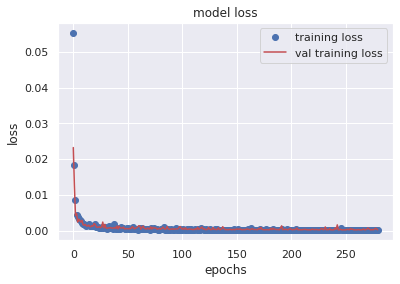

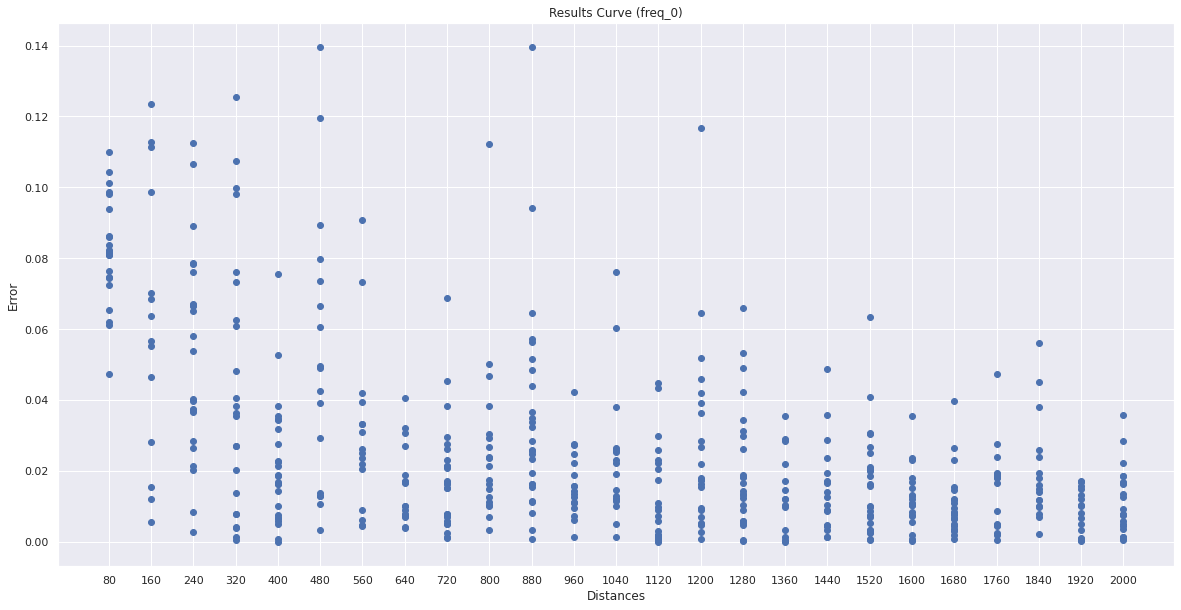

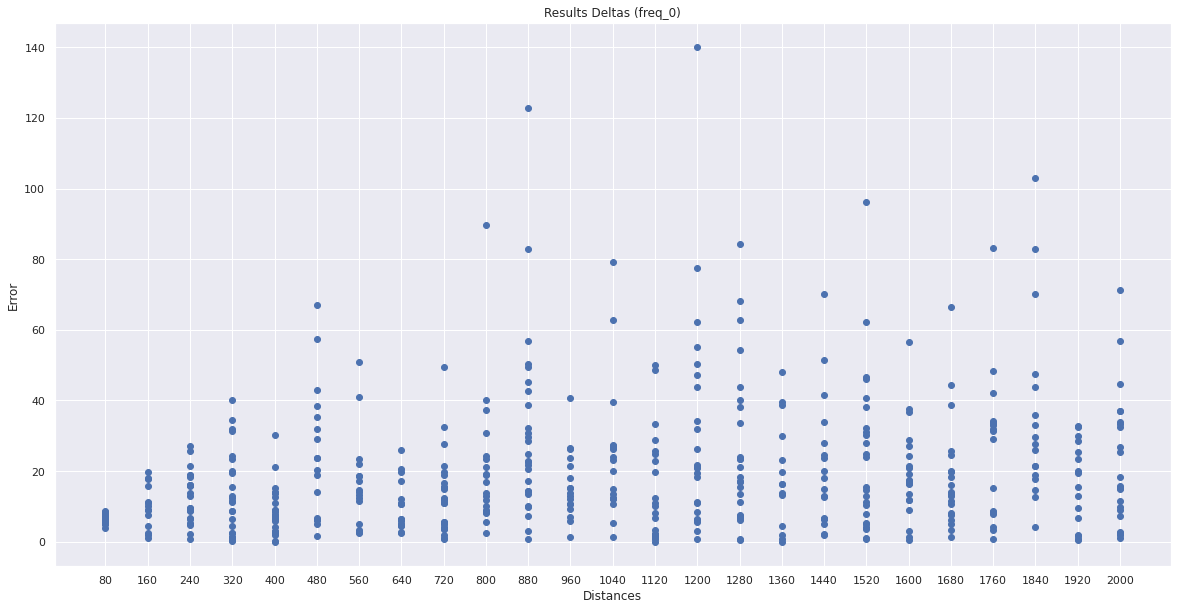

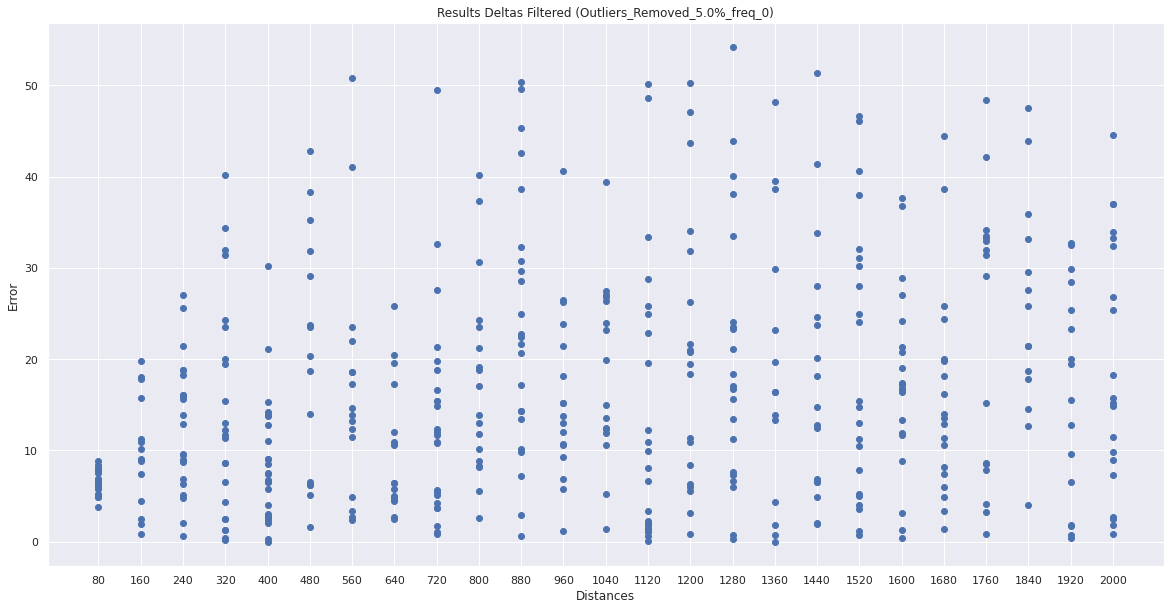

The R2 score on the Train set is:	0.999
The R2 score on the Test set is:	0.998
Accuracy is: 64.2% with a threshold of [20, 40, 60, 80]
Accuracy is: 88.6% with a threshold of [20, 40, 60, 80]
Accuracy is: 95.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 98.2% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 0

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 0
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


## test VAE

In [27]:
freq_amt = 0

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 0
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


In [60]:
# Load trained network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)
mm.model = load_model(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_0.h5")

In [61]:
# load vae data for test
dist = [80, 1040, 2000]

for d in dist:
  if d == 80:
    comb_mod_df = pd.read_csv(path+'/Spectrum/NN/revised_VAE/created_samples/generated_samples_distance_'+str(d)+'.csv')
  elif d == 1040:
    mod_data_df = pd.read_csv(path+'/Spectrum/NN/revised_VAE/created_samples/generated_samples_distance_'+str(d)+'.csv')
    c2 = comb_mod_df.append(mod_data_df)
  else:
    mod_data_df = pd.read_csv(path+'/Spectrum/NN/revised_VAE/created_samples/generated_samples_distance_'+str(d)+'.csv')
    c3 = c2.append(mod_data_df)
    c3.reset_index(drop=True, inplace=True)

Evaluating freq filter of: 0
The R2 score on the Test set is:	0.943
Accuracy is: 33.33% with a threshold of 20
Accuracy is: 33.33% with a threshold of 40
Accuracy is: 35.0% with a threshold of 60
Accuracy is: 35.0% with a threshold of 80


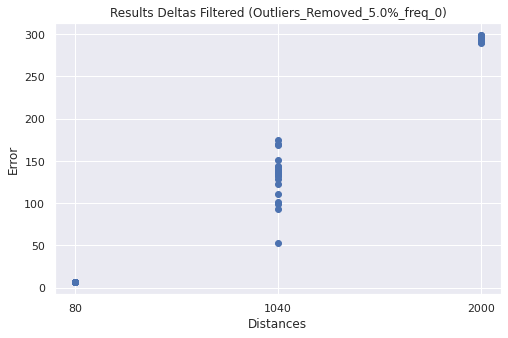

In [73]:
print('Evaluating freq filter of: '+ str(0))

x_test = c3.values[:, 1:]
scaler = MinMaxScaler()
data_scaler = scaler.fit(x_test)
x_test = data_scaler.transform(x_test)


y_test = c3.values[:, 0]

#------------------------------------------------------------------------------------------predict res with vae-------------------------------------------------------------
# Predit
y_test_pred=mm.predict(x_test)

dist_min=80
dist_max=2000

real_abs=y_test
real = list(y_test)
pred=list(y_test_pred)
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

num_of_remove_items = len(real) * 0.05

filtered_real_abs = real_abs
filtered_pred_abs = pred_abs
error_v2_filtered = error_v2
error_filtered = error
remove_cnt = 0
while remove_cnt <= num_of_remove_items:
  max_idx = np.where(error_v2_filtered == np.amax(error_v2_filtered))
  max_idx = max_idx[0][0]
  error_v2_filtered = np.delete(error_v2_filtered, max_idx)
  filtered_real_abs = np.delete(filtered_real_abs, max_idx)
  filtered_pred_abs = np.delete(filtered_pred_abs, max_idx)
  error_filtered = np.delete(error_filtered, max_idx)
  remove_cnt += 1

# Filtered Outliers
plt.figure(figsize=(8,5))
plt.plot(filtered_real_abs,error_v2_filtered,'bo')
plt.xlabel('Distances')
labels = [80, 1040, 2000]
plt.xticks(labels)
#plt.yticks(labels) 
plt.ylabel('Error') 
plt.title("Results Deltas Filtered (Outliers_Removed_"+str(0.05*100)+"%_freq_"+str(0)+")")
plt.savefig(path+"/Spectrum/NN/revised_VAE/VAE_distance_predictor_test"+str(0.05)+"%_freq_"+str(0)+"_epochs_"+str(100)+".png")
#------------------------------------------------------------------------------------------predict res with vae-------------------------------------------------------------


# Calculates and prints r2 score of training and testing data
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


In [ ]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=0.05, params_freq = 10, all_plots=True, epochs_num=600, training_data=False, save_res=False):
  print('Results (freq_'+str(params_freq)+')')
  # Predit

  Y_test_pred=model_ann.predict(X_test)

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  
  pred=list(Y_test_pred)
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  '''
  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)
  '''
  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  num_of_remove_items = len(real) * remove_outliers

  filtered_real_abs = real_abs
  filtered_pred_abs = pred_abs
  error_v2_filtered = error_v2
  error_filtered = error
  remove_cnt = 0
  while remove_cnt <= num_of_remove_items:
    max_idx = np.where(error_v2_filtered == np.amax(error_v2_filtered))
    max_idx = max_idx[0][0]
    error_v2_filtered = np.delete(error_v2_filtered, max_idx)
    filtered_real_abs = np.delete(filtered_real_abs, max_idx)
    filtered_pred_abs = np.delete(filtered_pred_abs, max_idx)
    error_filtered = np.delete(error_filtered, max_idx)
    remove_cnt += 1

  if all_plots == True:
    if save_res == True:
      res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
      res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_results_curve_freq_"+str(params_freq)+".csv", header=True, index=False)

      res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq)+".csv", header=True, index=False)
      
      plt.figure(figsize=(20,10))
      plt.plot(real_abs,error,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)      
      plt.title("Results Curve (freq_"+str(params_freq)+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_mod_bootstraped_new_data_results_curve_freq_"+str(params_freq)+".png")
      plt.show()
      
      plt.figure(figsize=(20,10))
      plt.plot(real_abs,error_v2,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)      
      plt.title("Results Deltas (freq_"+str(params_freq)+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_results_deltas_freq_"+str(params_freq)+".png")
      plt.show()

      # Filtered Outliers
      plt.figure(figsize=(20,10))      
      plt.plot(filtered_real_abs,error_v2_filtered,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      labels = [i*80 for i in range(1, 26)]
      plt.xticks(labels)
      plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq)+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+".png")
      plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.figure(figsize=(20,10))
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances')
    labels = [i*80 for i in range(1, 26)]
    plt.xticks(labels)
    #plt.yticks(labels) 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq)+")")
    if save_res == True:
      if training_data == False:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".png")   
      else:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/best_mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/best_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq)+"_epochs_"+str(epochs_num)+".png")
    plt.show()

  return error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs

## other test of tails

Evaluating freq filter of: 200
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_200)...
INFO:tensorflow:Assets written to: ram://2d5981c2-c12a-47a6-bb9c-3f2c96191004/assets
Results (freq_200)


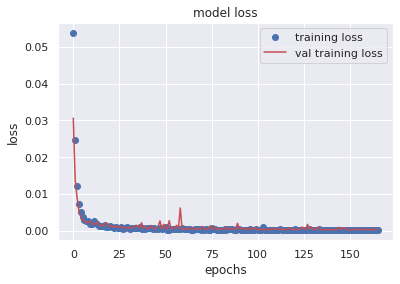

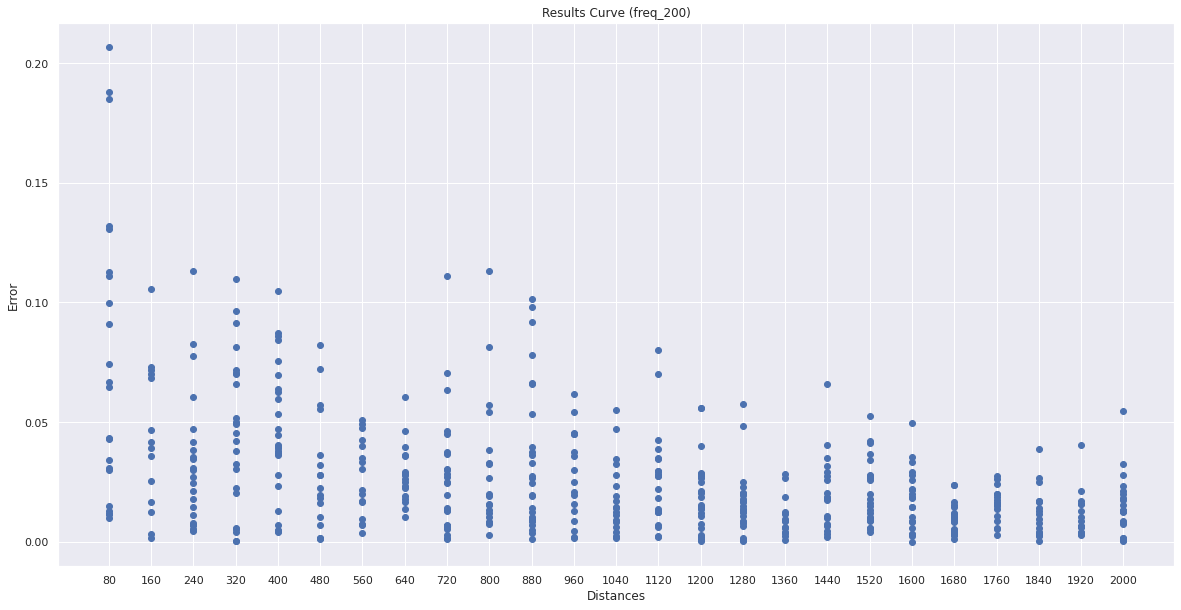

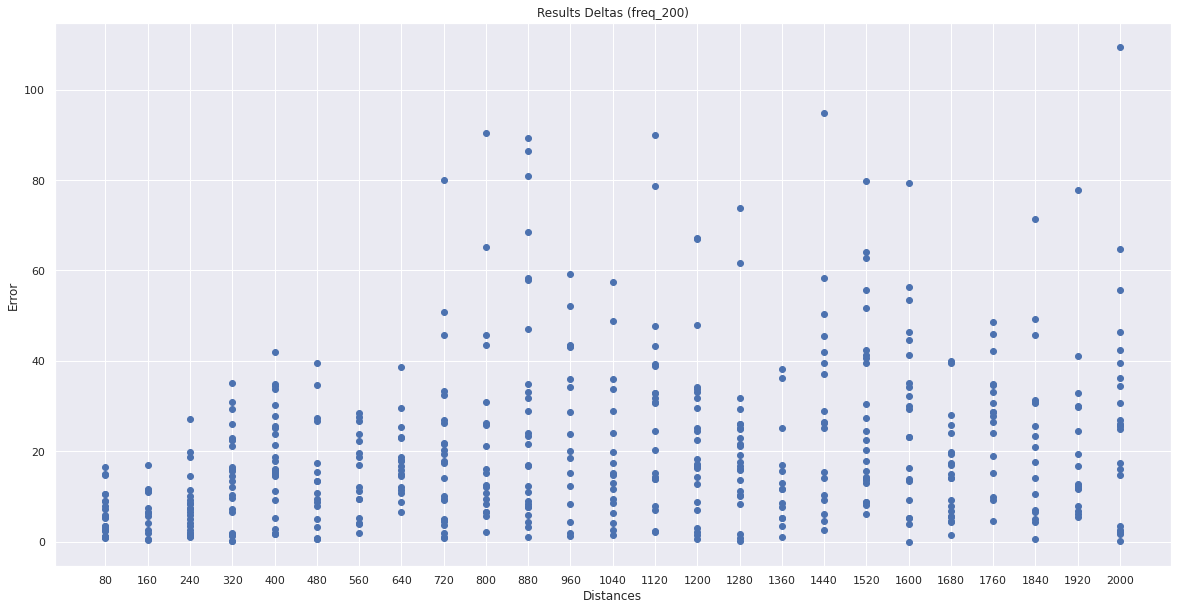

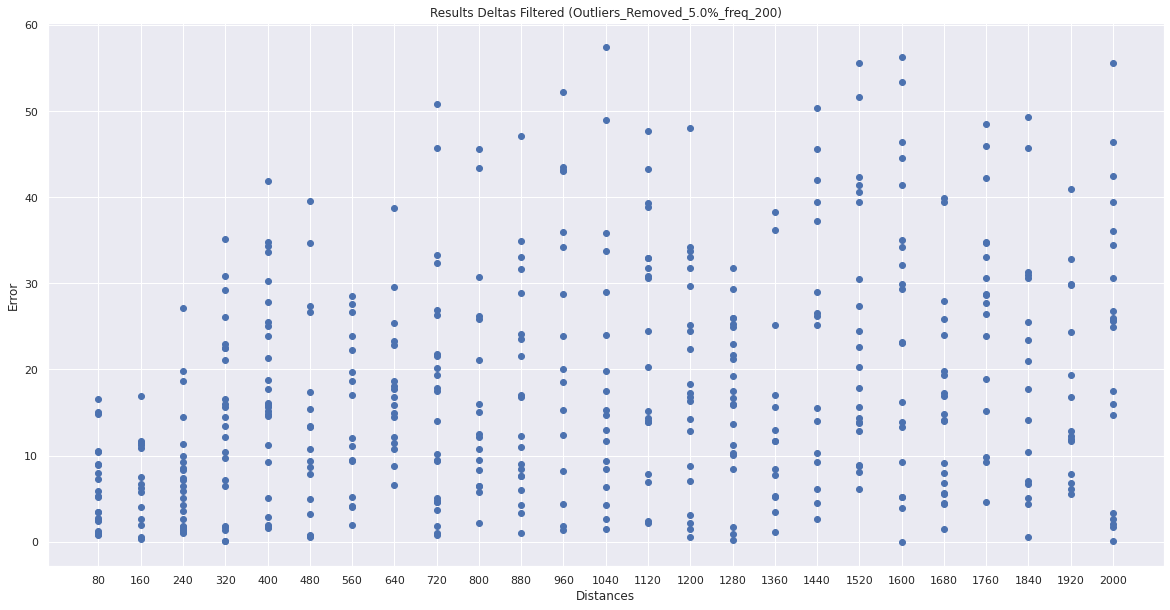

The R2 score on the Train set is:	0.999
The R2 score on the Test set is:	0.998
Accuracy is: 59.4% with a threshold of [20, 40, 60, 80]
Accuracy is: 87.4% with a threshold of [20, 40, 60, 80]
Accuracy is: 95.6% with a threshold of [20, 40, 60, 80]
Accuracy is: 98.4% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 200

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 200
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


Evaluating freq filter of: 400
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_400)...
INFO:tensorflow:Assets written to: ram://5b70ea77-c7c6-4c61-8246-cdf54c284bcf/assets
Results (freq_400)


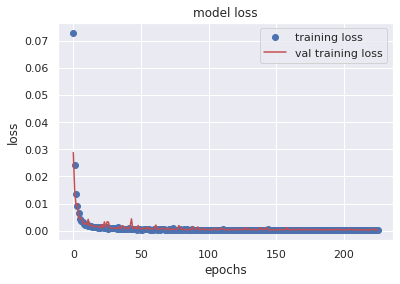

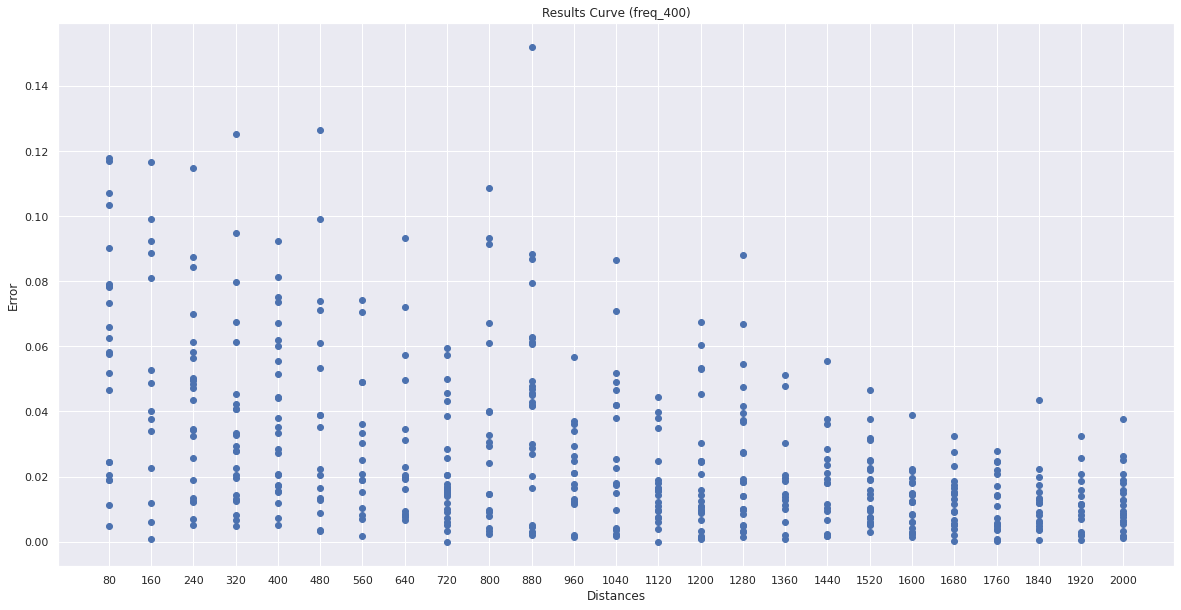

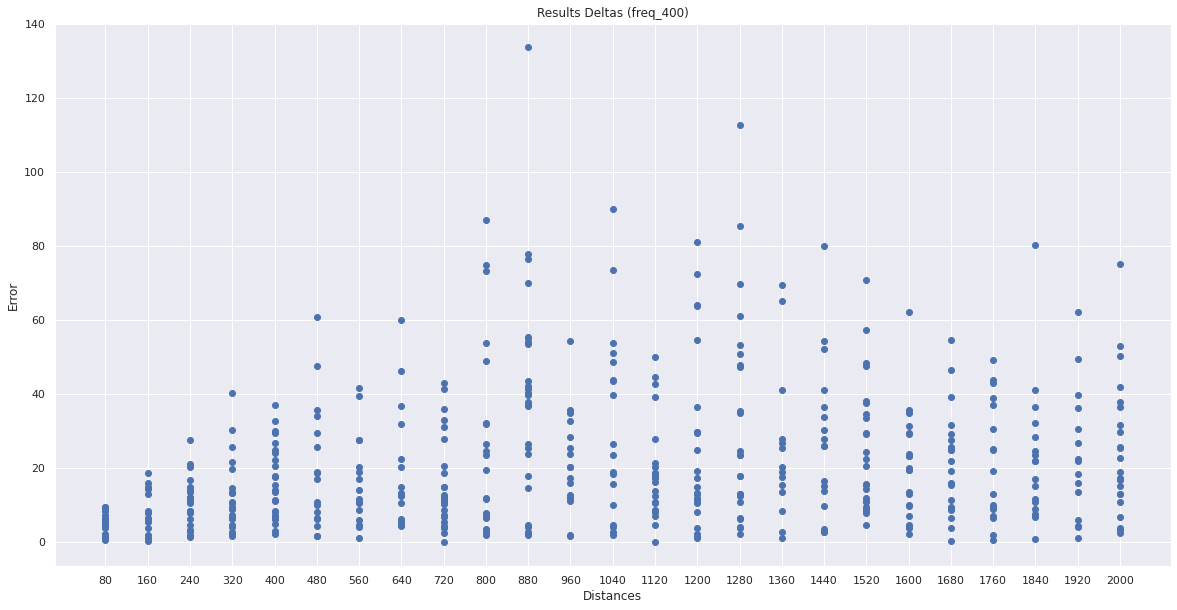

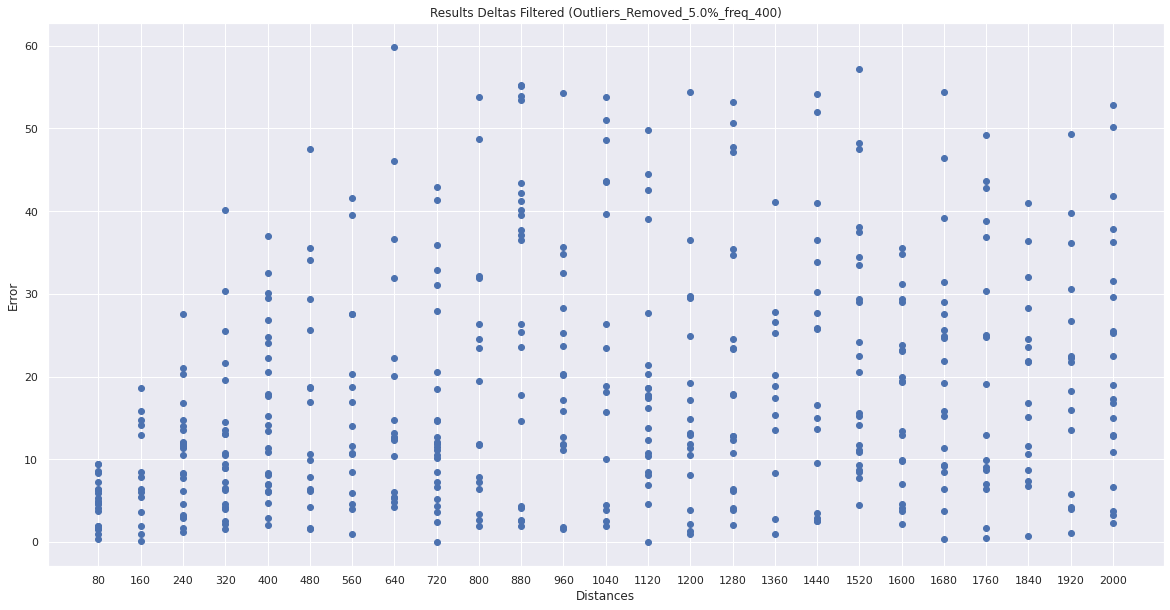

The R2 score on the Train set is:	0.999
The R2 score on the Test set is:	0.997
Accuracy is: 59.2% with a threshold of [20, 40, 60, 80]
Accuracy is: 85.2% with a threshold of [20, 40, 60, 80]
Accuracy is: 94.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 98.6% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 400

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 400
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


Evaluating freq filter of: 600
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_600)...
INFO:tensorflow:Assets written to: ram://3f0b89ce-41a0-45cc-8be4-0df962a793d0/assets
Results (freq_600)


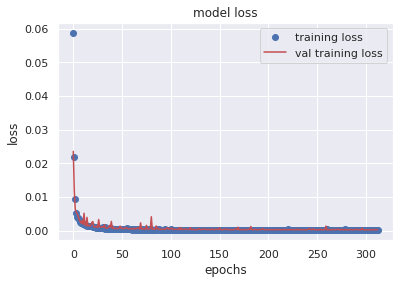

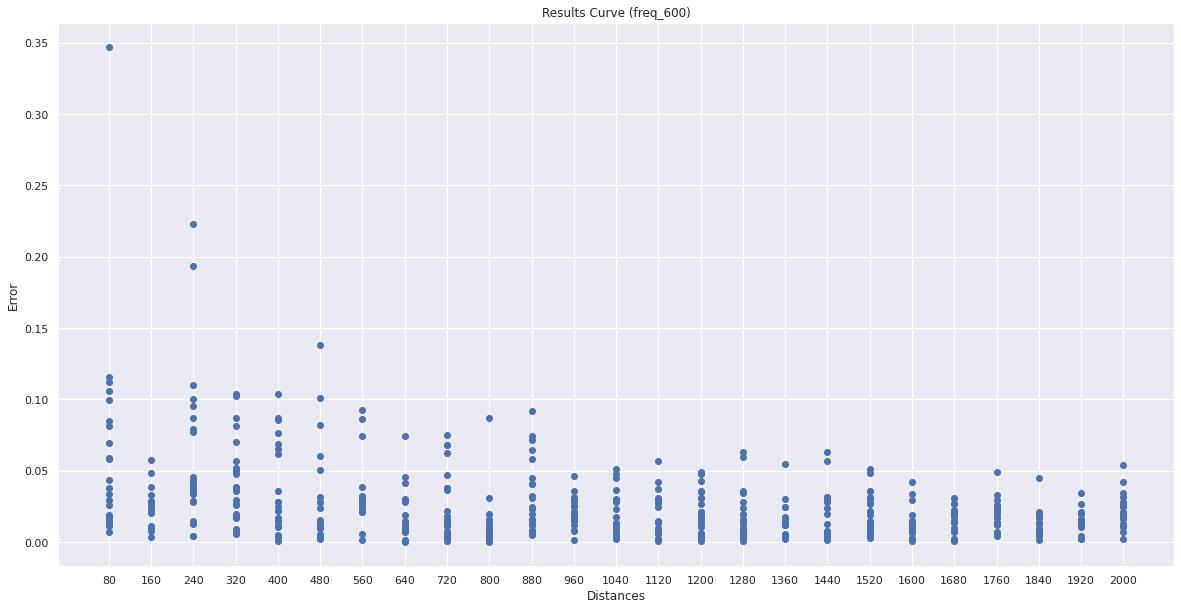

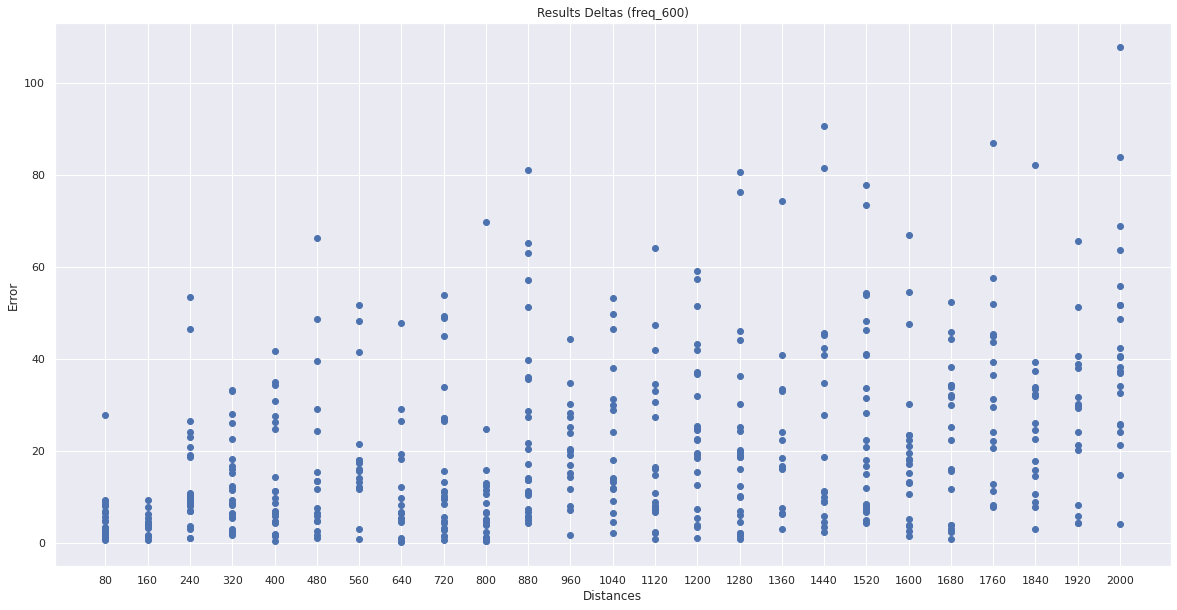

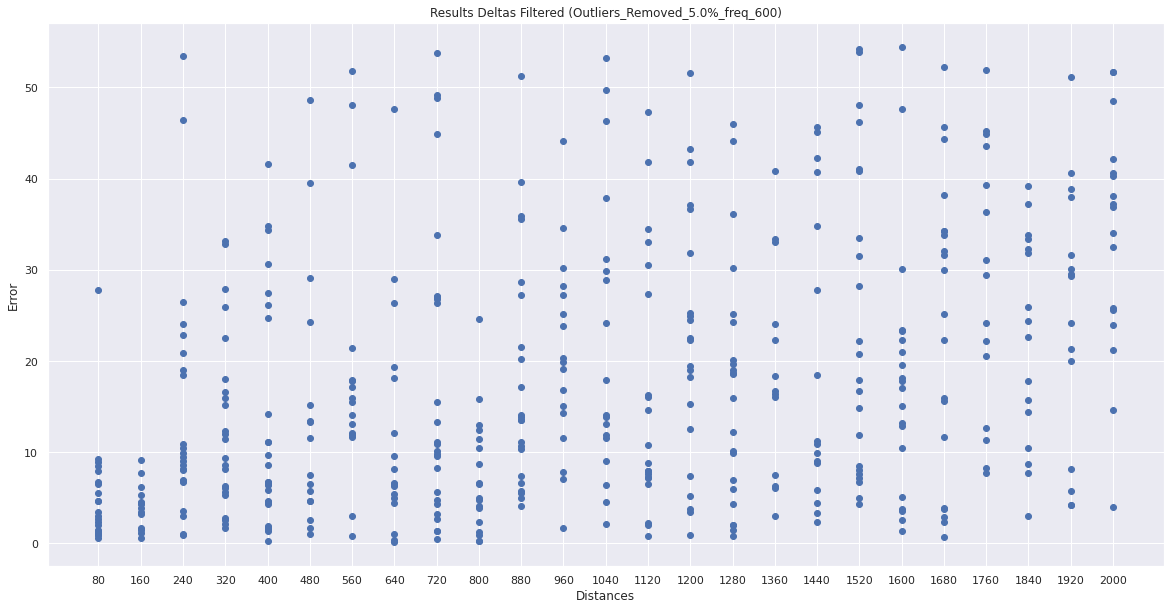

The R2 score on the Train set is:	0.999
The R2 score on the Test set is:	0.998
Accuracy is: 59.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 84.4% with a threshold of [20, 40, 60, 80]
Accuracy is: 95.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 98.4% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 600

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 600
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


Evaluating freq filter of: 800
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_800)...
INFO:tensorflow:Assets written to: ram://171af085-dfcf-440f-88b1-e2ea9d0c5912/assets
Results (freq_800)


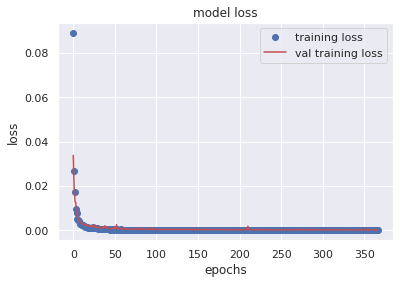

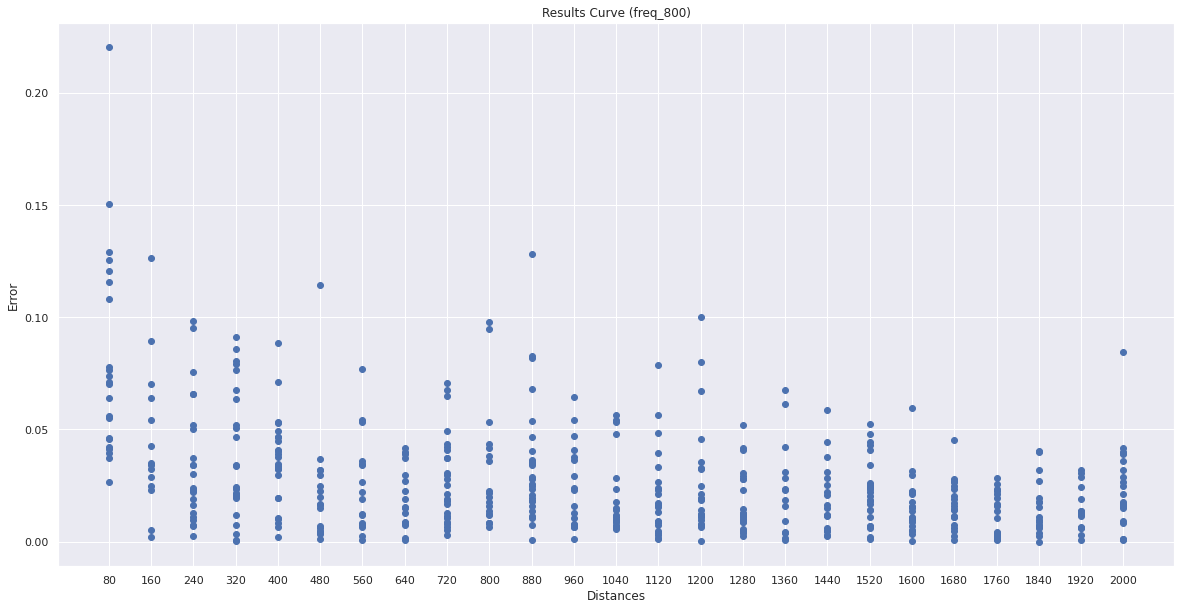

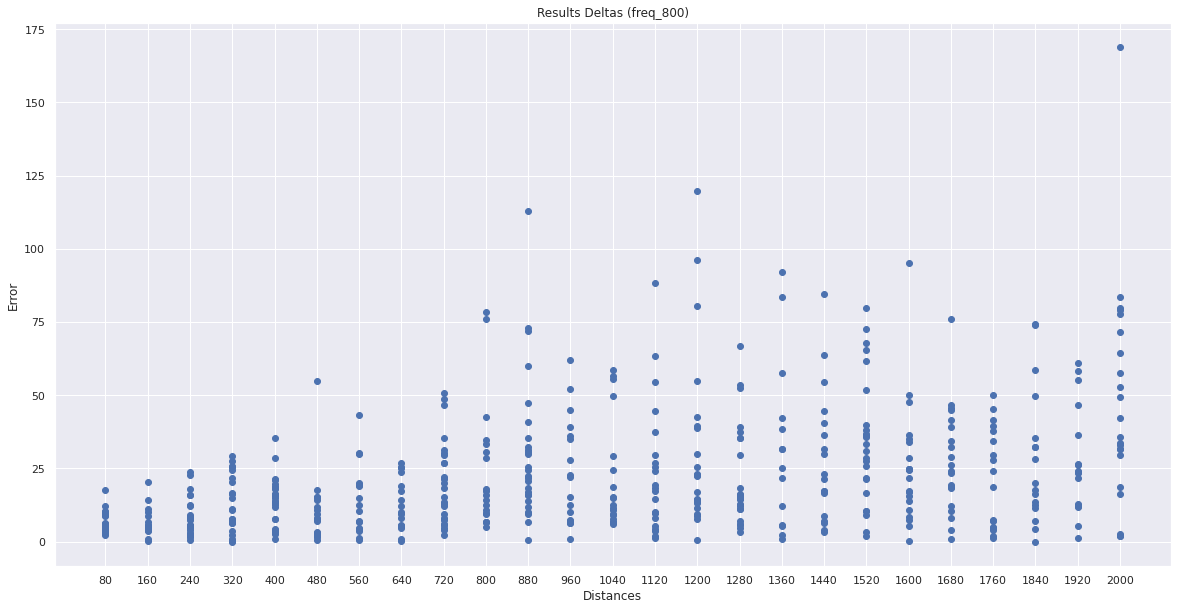

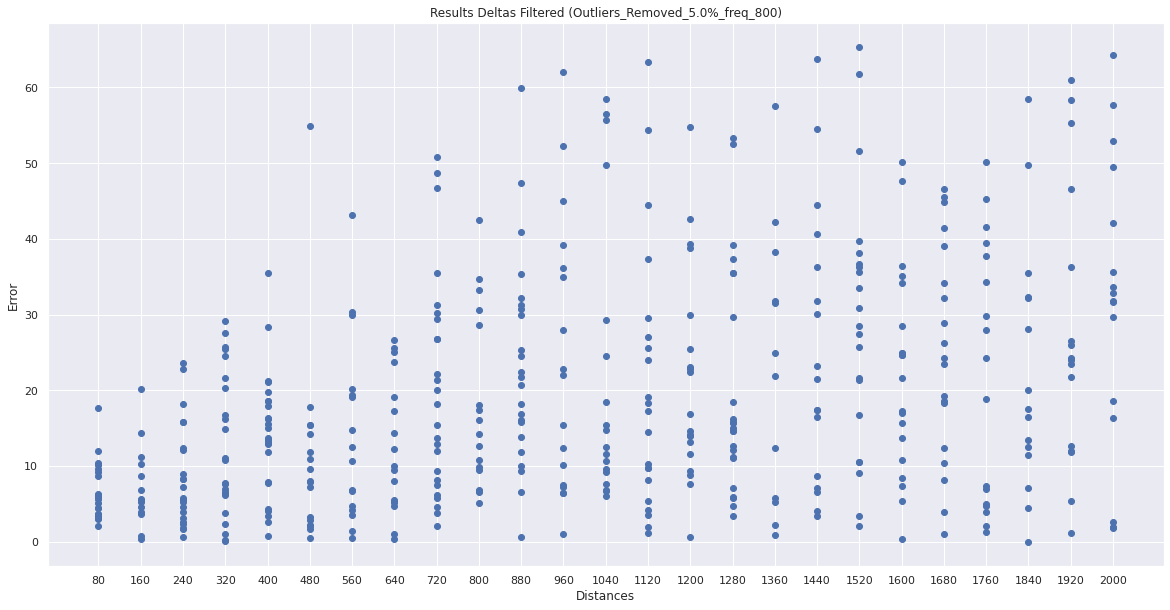

The R2 score on the Train set is:	0.998
The R2 score on the Test set is:	0.997
Accuracy is: 58.2% with a threshold of [20, 40, 60, 80]
Accuracy is: 84.4% with a threshold of [20, 40, 60, 80]
Accuracy is: 93.4% with a threshold of [20, 40, 60, 80]
Accuracy is: 97.8% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 800

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 800
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


Evaluating freq filter of: 1000
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_1000)...
INFO:tensorflow:Assets written to: ram://5cc16a2d-7897-492c-95a0-5a997bcfc498/assets
Results (freq_1000)


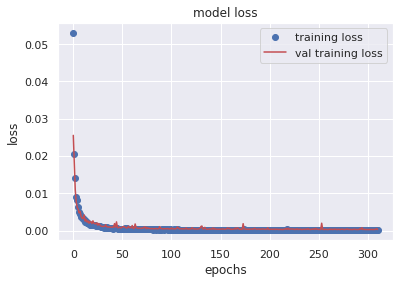

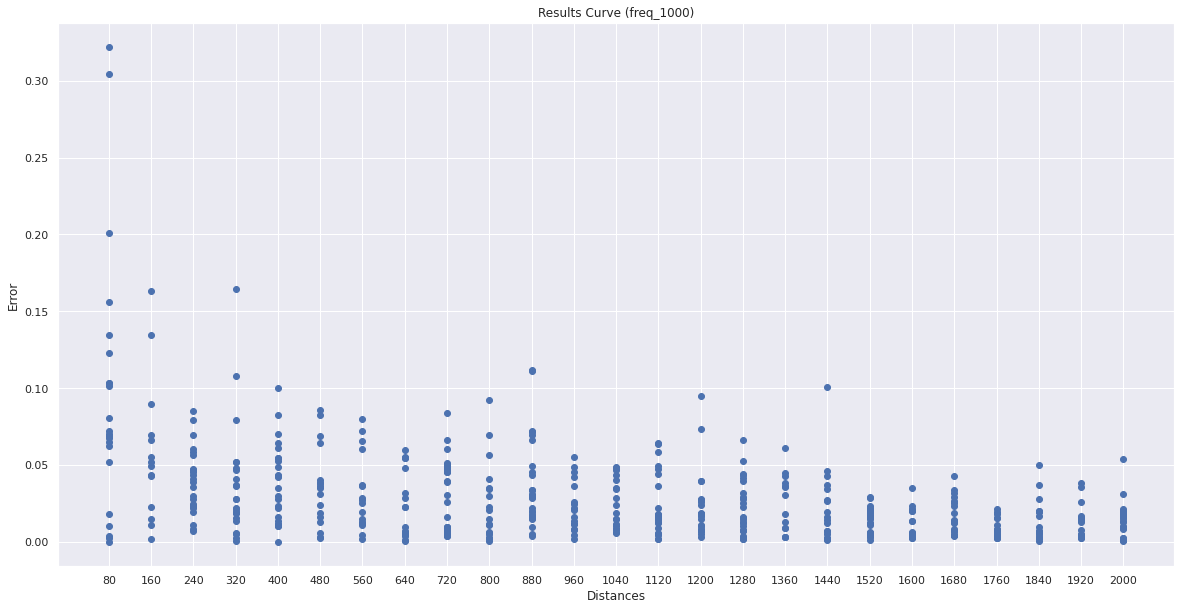

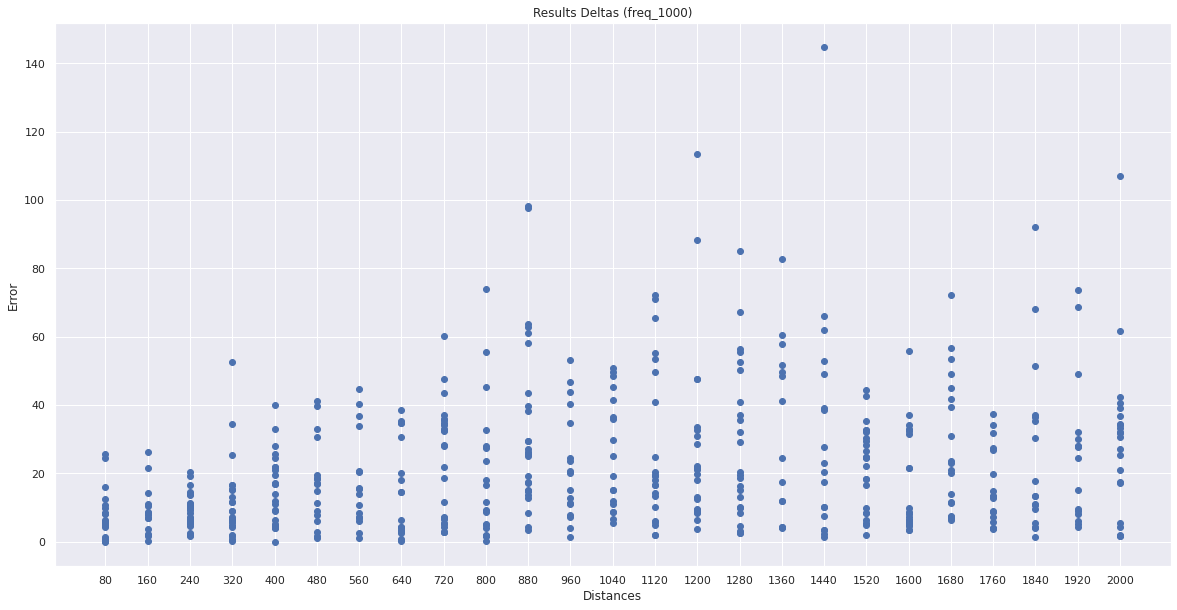

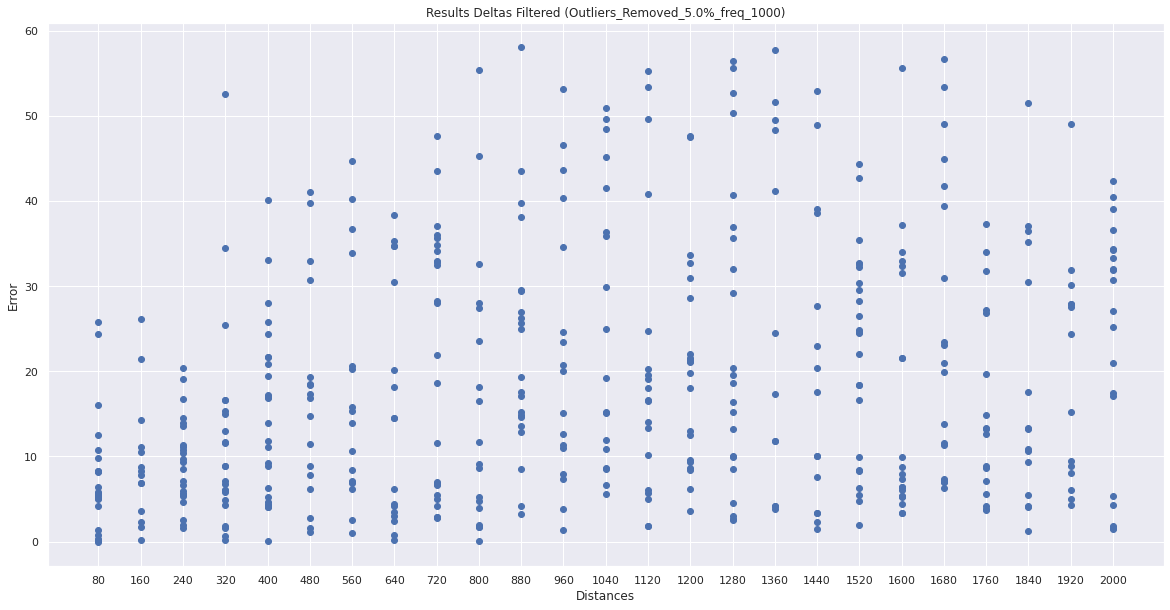

The R2 score on the Train set is:	0.999
The R2 score on the Test set is:	0.997
Accuracy is: 58.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 84.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 94.8% with a threshold of [20, 40, 60, 80]
Accuracy is: 98.2% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 1000

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 1000
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))


Evaluating freq filter of: 1200
Obtaining data filtered by frequencies...
Obtaining train and test split...
Done
Training model (freq_1200)...
INFO:tensorflow:Assets written to: ram://21f69342-b905-44b1-84d3-5257e4ebe8b9/assets
Results (freq_1200)


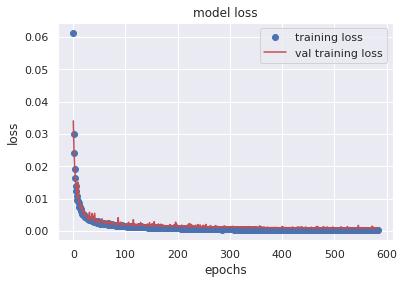

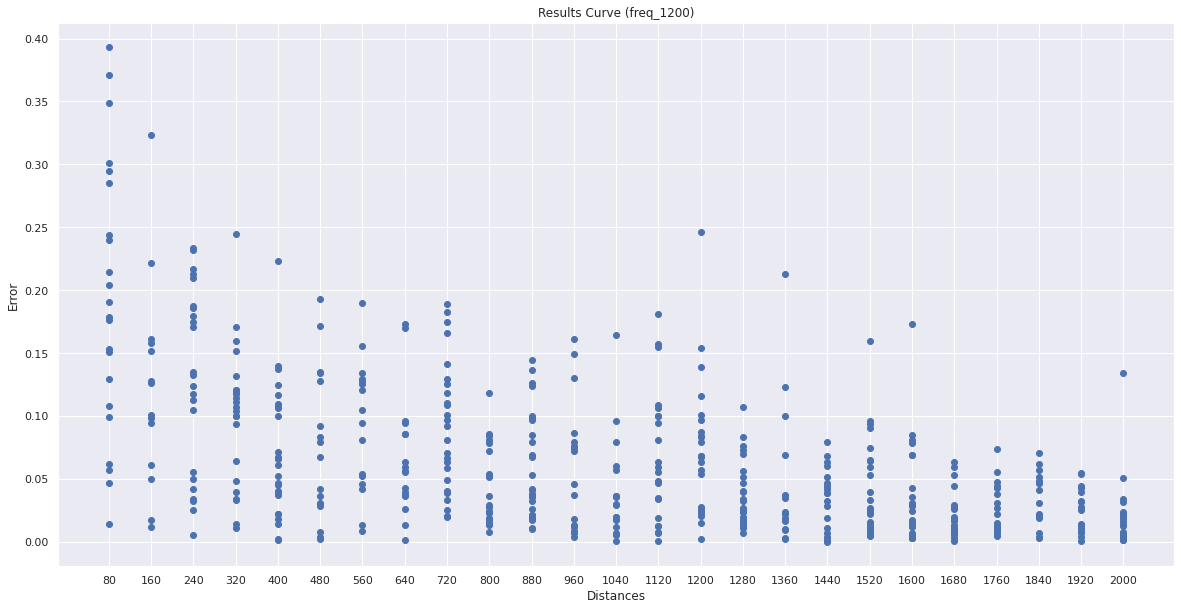

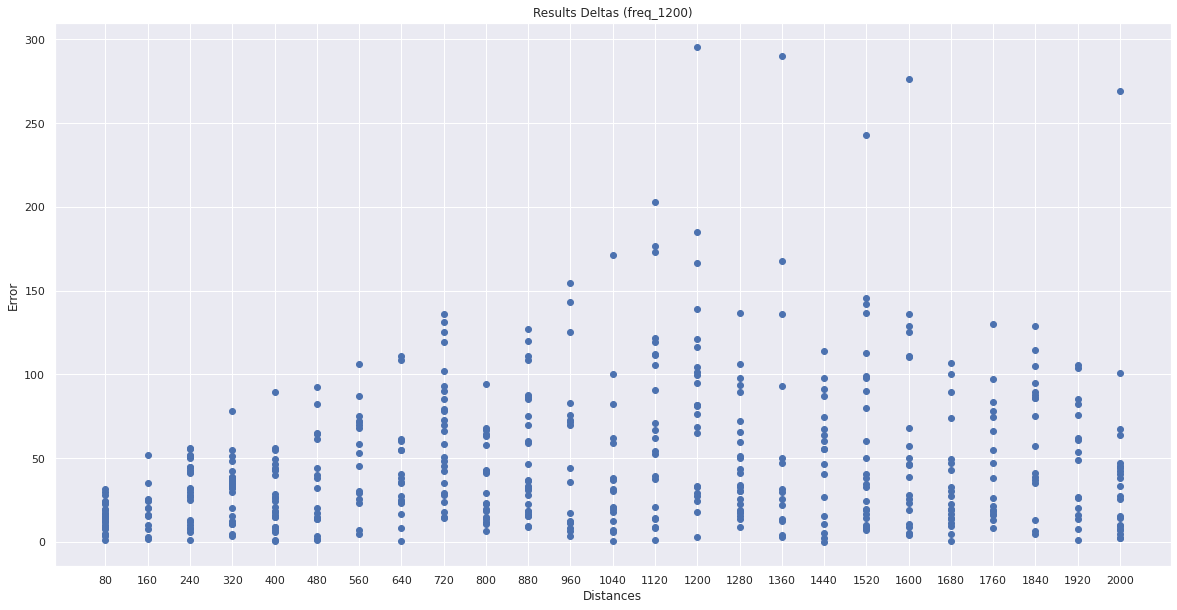

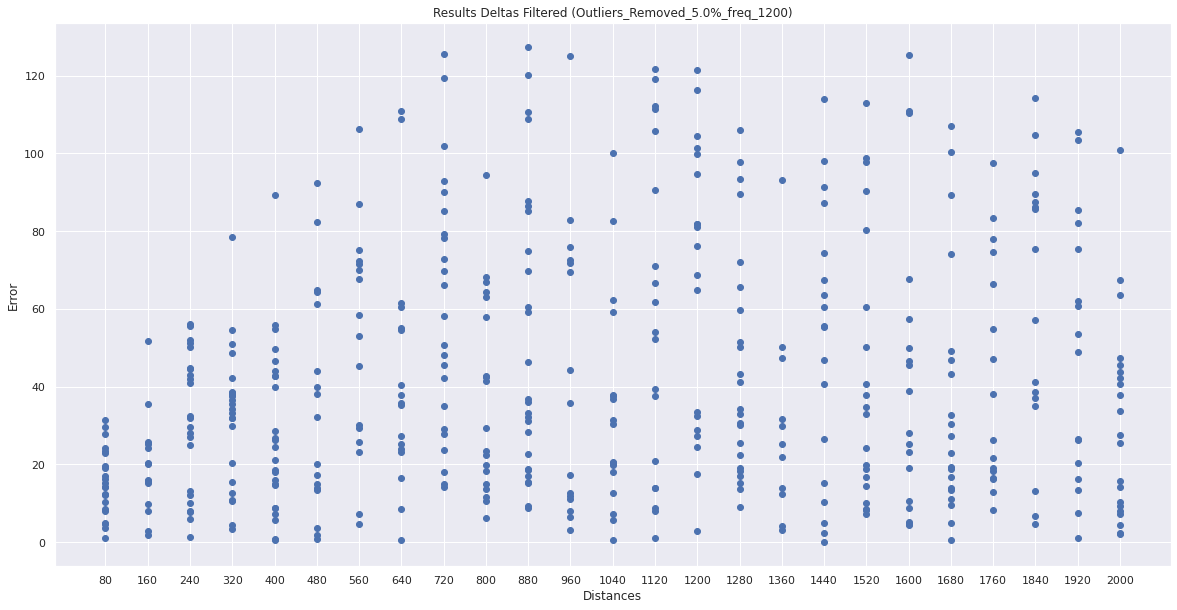

The R2 score on the Train set is:	0.995
The R2 score on the Test set is:	0.987
Accuracy is: 31.2% with a threshold of [20, 40, 60, 80]
Accuracy is: 54.6% with a threshold of [20, 40, 60, 80]
Accuracy is: 69.6% with a threshold of [20, 40, 60, 80]
Accuracy is: 80.0% with a threshold of [20, 40, 60, 80]


In [ ]:
freq_amt = 1200

# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  f_amt = 1200
  input_size = 2561 - (f_amt*2)
  model = Sequential()
  model.add(Dense(76, input_dim = input_size, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected):
  print('Training model (freq_'+str(num_of_freq_selected)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+".h5")
  
  return model_ann


# -----------------------------------------------------------------------------------------

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"


print('Evaluating freq filter of: '+ str(freq_amt))
x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(input_path, num_features = freq_amt, test_size=0.2, equaly_separated=False,  split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

input_size = x_train.shape[1]

model_ann = train_model(x_train, y_train_norm, freq_amt)

error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq = freq_amt, 
                                                                                      all_plots=True, epochs_num='test', training_data=False, save_res=True)

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

threshold_vals = [20, 40, 60, 80]
for v in threshold_vals:
  res_predictions, accuracy = threshold_review(y_test_norm, y_test_pred, threshold = v)
  print('Accuracy is: '+str(accuracy)+'% with a threshold of '+str(v))
